In [20]:
import numpy as np
import pandas as pd

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import zscore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from itertools import product

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [21]:
# Load datasets
sp500_train = pd.read_csv('Datasets/sp500_train.csv', index_col='Date', parse_dates=True)
sp500_test = pd.read_csv('Datasets/sp500_test.csv', index_col='Date', parse_dates=True)
tesla_train = pd.read_csv('Datasets/tesla_train.csv', index_col='Date', parse_dates=True)
tesla_test = pd.read_csv('Datasets/tesla_test.csv', index_col='Date', parse_dates=True)

In [22]:
# Check for missing values
print("Missing values in sp500_train:", sp500_train.isnull().sum().sum())
print("Missing values in sp500_test:", sp500_test.isnull().sum().sum())
print("Missing values in tesla_train:", tesla_train.isnull().sum().sum())
print("Missing values in tesla_test:", tesla_test.isnull().sum().sum())


Missing values in sp500_train: 0
Missing values in sp500_test: 0
Missing values in tesla_train: 0
Missing values in tesla_test: 0


In [23]:
#Stationarity test
from statsmodels.tsa.stattools import adfuller
results = adfuller(sp500_train['Close'])
print('ADF Statistic:', results[0])
print('p-value:', results[1])


ADF Statistic: -1.0049846156671072
p-value: 0.7514419382338596


Text(0, 0.5, 'ACF')

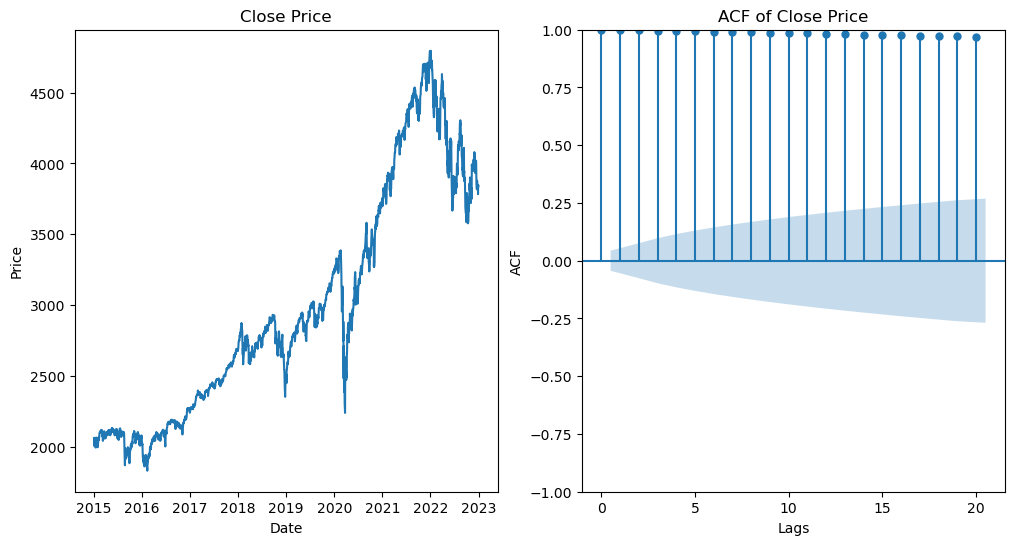

In [24]:
#ACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(sp500_train['Close'], label='Close Price')
ax1.set_title('Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

plot_acf(sp500_train['Close'], lags=20, ax=ax2)
ax2.set_title('ACF of Close Price')
ax2.set_xlabel('Lags')
ax2.set_ylabel('ACF')


1
ADF Statistic: -14.159818617630076
p-value: 2.0904969591391718e-26


Text(0, 0.5, 'ACF')

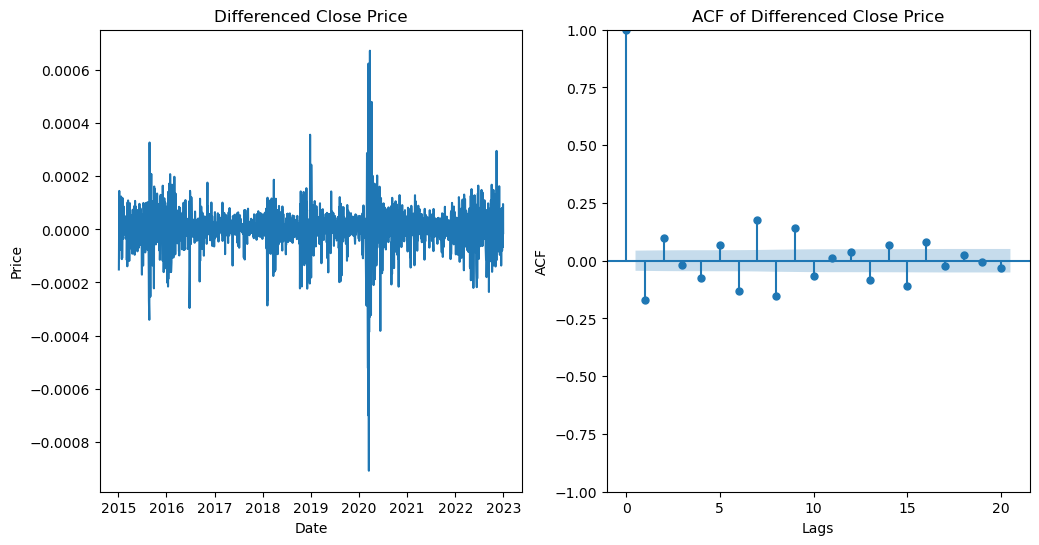

In [25]:
# Differecing since data in not stationary based on ADF test

# Checking the number of differences needed to make the series stationary
from pmdarima.arima.utils import ndiffs
from scipy.stats import boxcox
from scipy.special import inv_boxcox
print(ndiffs(sp500_train['Close']))


sp500_boxcox, lam = boxcox(sp500_train['Close'])
sp500_boxcox = pd.Series(sp500_boxcox, index=sp500_train.index)
sp500_diff = sp500_boxcox.diff().dropna()


results = adfuller(sp500_diff)
print('ADF Statistic:', results[0])
print('p-value:', results[1])

# Plot the differenced data
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))
ax1.plot(sp500_diff, label='Differenced Close Price')
ax1.set_title('Differenced Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

plot_acf(sp500_diff, lags=20, ax=ax2)
ax2.set_title('ACF of Differenced Close Price')
ax2.set_xlabel('Lags')
ax2.set_ylabel('ACF')




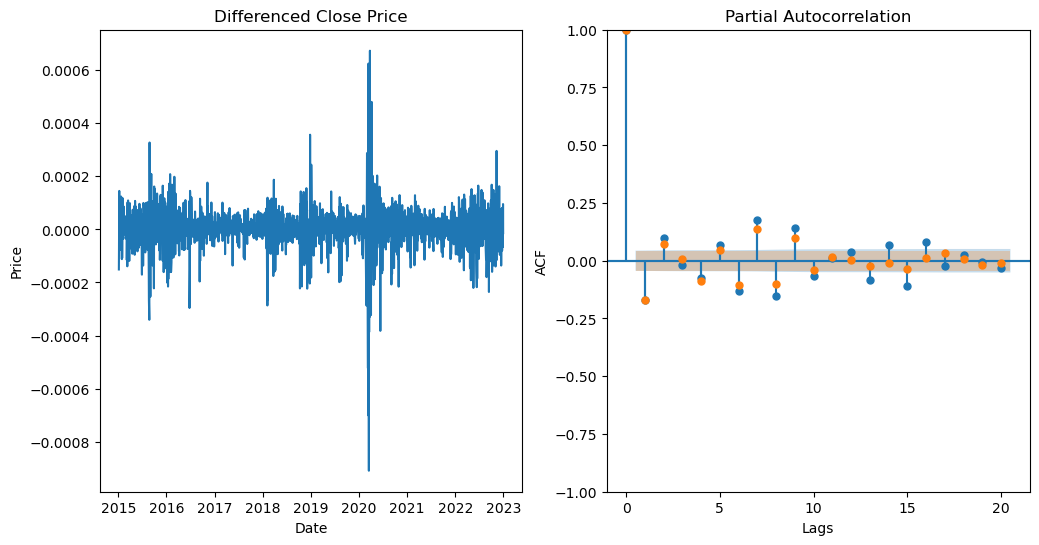

In [26]:
plot_pacf(sp500_diff, lags=20, ax=ax2)



In [27]:
p_values = range(0, 11)
q_values = range(0, 11)
d_values = range(1, 3) 

# Function to evaluate ARIMA model
def evaluate_arima_model(train, test, arima_order):
    try:        
        # Box-Cox transformation
        #train_boxcox, lam = boxcox(train)
        #train_boxcox = pd.Series(train_boxcox, index=train.index)

        # Fit ARIMA model
        model = ARIMA(train, order=arima_order)
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(test))
        #if np.any(predictions <= 0):
        #    raise ValueError(f"Predictions contain non-positive values for ARIMA order {arima_order}")
        
        #inverse boxcox transformation
        #predictions = inv_boxcox(predictions, lam)
        #predictions = pd.DataFrame(predictions, index=test.index)
        
        #Compute RMSE, MAE, MAPE
        rmse = np.sqrt(mean_squared_error(test, predictions))
        mae = mean_absolute_error(test, predictions)
        mape = mean_absolute_percentage_error(test, predictions)
        #zs = zscore(test - predictions)
        return rmse, mae, mape, model_fit, predictions
    except Exception as e:
        print(f"Error for ARIMA order {arima_order}: {e}")  # Print the error message
        return None, None, None, None, None
    
    # Running ARIMA model with different p, d, q values
results = []
for p,q,d in product(p_values, q_values, d_values):
    arima_order = (p, d, q)
    rmse, mae, mape, model_fit, predictions = evaluate_arima_model(sp500_train['Close'], sp500_test['Close'], arima_order)
    results.append((arima_order, rmse, mae, mape, model_fit))


    '''if model_fit is not None:
        plt.figure(figsize=(12, 6))
        plt.plot(sp500_test['Close'], label='Test Data')
        plt.plot(sp500_train['Close'], label='Train Data')
        plt.plot(predictions, label='Predictions', color='red')
        plt.title(f'ARIMA{arima_order} Predictions')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.show()
    '''
    



In [28]:
print(results)
results = [result for result in results if result[1] is not None and result[2] is not None and result[3] is not None]
print(f"Total models evaluated: {len(results)}")
best_model_rmse = min(results, key=lambda x: x[1])
best_model_mae = min(results, key=lambda x: x[2])
best_model_mape = min(results, key=lambda x: x[3])

print(f"Best model RMSE is {best_model_rmse[0]} with RMSE: {best_model_rmse[1]}")
print(f"Best model MAR is {best_model_mae[0]} with MAE: {best_model_mae[2]}")
print(f"Best model MAPE is {best_model_mape[0]} with MAPE: {best_model_mape[3]}")

[((0, 1, 0), 1205.806667720945, 1016.9061876247505, 0.1953878158412367, <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x00000296B02697E0>), ((0, 2, 0), 4032.223798028151, 3471.53737300764, 0.6717923577146415, <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x00000296B0278EB0>), ((0, 1, 1), 1205.4994430962565, 1016.5447164219083, 0.19531221336515484, <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x00000296B027AAA0>), ((0, 2, 1), 980.8641472869924, 820.2383987314474, 0.15722714712516273, <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x00000296B027BD00>), ((0, 1, 2), 1202.484786941372, 1012.9958162041246, 0.19456995582834938, <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x00000296B02C8C10>), ((0, 2, 2), 960.7326223829812, 802.490507814555, 0.15377764346890024, <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x00000296B02C9F30>), ((0, 1, 3), 1202.6373826732613, 1013.1793187878103, 0.19460853731751016, <statsmodels.t

Best ARIMA order for SP500: (8, 2, 0)


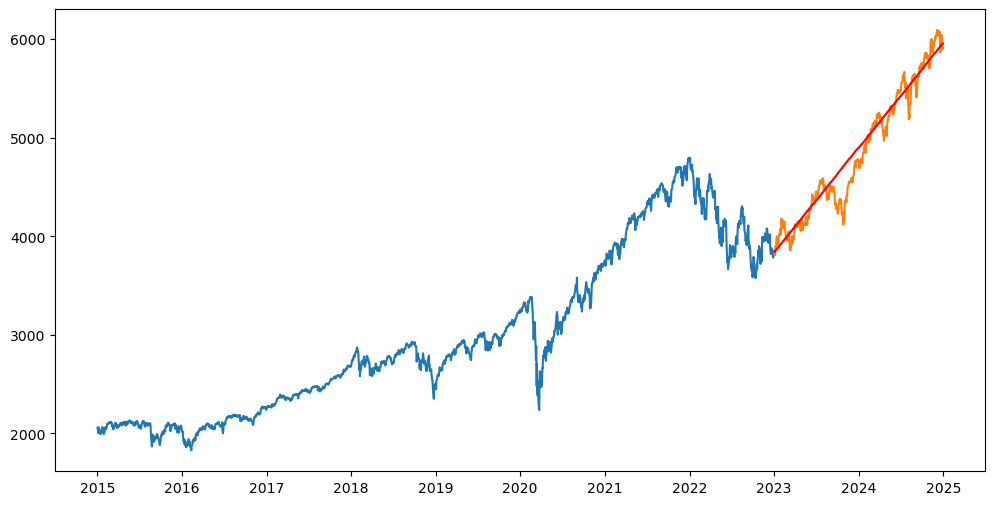

In [33]:
#ARIMA model
autoarima = auto_arima(sp500_test, seasonal=False, max_p=20, d=2, max_q=20, suppress_warnings=True)
print("Best ARIMA order for SP500:", autoarima.order)

sp500_model = ARIMA(sp500_train, order=(5, 2, 0))
sp500_model_fit = sp500_model.fit()

steps_sp500 = len(sp500_test)
sp500_forecast_fit = sp500_model_fit.get_forecast(steps=steps_sp500)
arima_pred_sp500 = sp500_forecast_fit.predicted_mean
#arima_pred_sp500 = inv_boxcox(arima_pred_sp500, lam)
arima_pred_sp500.index = sp500_test.index
arima_conf_sp500 = sp500_forecast_fit.conf_int(alpha=0.05)
arima_conf_sp500.index = sp500_test.index

plt.figure(figsize=(12, 6))
plt.plot(sp500_train['Close'], label='Train Data')
plt.plot(sp500_test['Close'], label='Test Data')
plt.plot(arima_pred_sp500, label='ARIMA Forecast', color='red')